In [1]:
#############################################################################################
# The code is running with Tensroflow 1.15 
# on docker tensorflow/tensorflow:1.15.0-gpu-py3 (with additional packages: scikit/scikit-image/keras)
# And I add import tensorflow.compatv1 as tf in the original project
#############################################################################################
# I met
# Error : Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
# https://github.com/tensorflow/tensorflow/issues/24828
# Suggests the following solution

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config0 = ConfigProto()
config0.gpu_options.allow_growth = True
#for multiple GPUs
config0.allow_soft_placement=True
session = InteractiveSession(config=config0)

####################################################################

# return a list of the file nmaes in the dirtory
from os import listdir
# extracting bounding boxes from an annotation file
#to get the treee from the xml file
from xml.etree import ElementTree 
from numpy import zeros
from numpy import asarray
# Dataset is a class defined in the project
# We need to define load_dataset / load_mask / image_refernce by ourselves
from mrcnn.utils import Dataset # DIfferent from the tutorial why?

import csv
import pandas as pd 
from PIL import Image
import numpy as np

from matplotlib import pyplot

In [2]:
image_dir = '/HDD1/Downloads/OpenImageV5/Train/'

In [3]:
data_dir = '/HDD1/Downloads/OpenImageV5/MyData/'
# read the list of image IDs
with open(data_dir+'training_image_list.csv','r') as f:
    reader = csv.reader(f)
    training_image_list = list(reader)[0]
with open(data_dir+'validation_image_list.csv','r') as f:
    reader = csv.reader(f)
    validation_image_list = list(reader)[0]
with open(data_dir+'test_image_list.csv','r') as f:
    reader = csv.reader(f)
    test_image_list = list(reader)[0]

with open(data_dir+'all_image_list.csv','r') as f:
    reader = csv.reader(f)
    all_image_list = list(reader)[0]

# read the boxes
training_dataset = pd.read_csv(data_dir+'training_dataset.csv')
validation_dataset = pd.read_csv(data_dir+'validation_dataset.csv')
test_dataset = pd.read_csv(data_dir+'test_dataset.csv')
all_dataset = pd.read_csv(data_dir+'all_dataset.csv')

In [4]:
# load the classs imformation
with open(data_dir+'class-descriptions-boxable.csv','r') as f:
    reader = csv.reader(f)
    class_file = list(reader)

In [5]:
# define a dataset class
# based on the Dataset class
class OpenImageDataset(Dataset):
    def load_dataset(self,dataset_dir,is_train=True):
        #define one class
        # add_class is built in the original class
        for i in range(len(class_file)):
            self.add_class("OpenImage",i+1,class_file[i][1])
        
        if is_train:
            for image_id in range(len(training_image_list)):
                img_path = image_dir + all_image_list[image_id] + ".jpg"
                self.add_image('OpenImage',image_id=image_id,path=img_path)
        if not is_train:
            # because we do not change the hyperparameters in the project
            # I use the valiataiton and test set as test set
            for image_id in range(len(training_image_list),len(all_image_list)):
                img_path = image_dir + all_image_list[image_id] + ".jpg"
                self.add_image('OpenImage',image_id=image_id,path=img_path)
            
    # define a function to extract the boxes from csv[ done 11.11]
    def extract_boxes(self,image_name):
        # find the lines with imageID
        image_data = all_dataset.loc[all_dataset['ImageID']==image_name]
        
        # extract image dimensions
        image=Image.open(image_dir+image_name+'.jpg')
        width,height = image.size
        
        # extract all the bounding boxes
        boxes = list()
        class_label = list()
        for index,row in image_data.iterrows():
            #because in this dataset, XMin is shown in numbers like 0.234
            xmin = round(width*row['XMin'])
            ymin = round(height*row['YMin'])
            xmax = round(width*row['XMax'])
            ymax = round(height*row['YMax'])
            boxes.append([xmin,ymin,xmax,ymax])
            class_label.append(row['LabelName'])
        
        # obtain class id 
        class_ids = list()
        for label in class_label:
            # search for the label in first column of the file
            index = np.array(class_file)[:,0].tolist().index(label)
            class_ids.append(class_file[index][1])
        
        return boxes, width, height, class_ids
    
    def load_mask(self,image_id):
        # from image_id to image_name
        image_name = all_image_list[image_id]
        # call extract_boxes tp get the bboxes and w,h
        boxes,w,h,class_ids_name = self.extract_boxes(image_name)
        # create masks
        masks = zeros([h,w,len(boxes)]) # could be multiple boxes
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            col_start, col_end = box[0],box[2]
            row_start, row_end = box[1],box[3]
            masks[row_start:row_end,col_start:col_end,i] = 1
            # record the class of each box
            class_ids.append(self.class_names.index(class_ids_name[i]))
        return masks, asarray(class_ids,dtype='int32')
    
    # image_id must be int
    def image_reference(self,image_id):
        info = self.image_info[image_info]
        return info['path']

In [6]:
train_set = OpenImageDataset() 

train_set.load_dataset('OpenImage',is_train=True)

train_set.prepare() # what does this for? It's necessary but why?

print('Train: %d' % len(train_set.image_ids))

Train: 80000


In [7]:
test_set = OpenImageDataset() 

test_set.load_dataset('OpenImage',is_train=False)

test_set.prepare() # what does this for? It's necessary but why?

print('Test: %d' % len(test_set.image_ids))

Test: 20000


In [8]:
#########################################################################################

In [9]:
# test the load_image and load_mask function
image_id = 300
image = train_set.load_image(image_id)
# print(image)
mask, class_ids = train_set.load_mask(image_id)
# print(mask,class_ids)

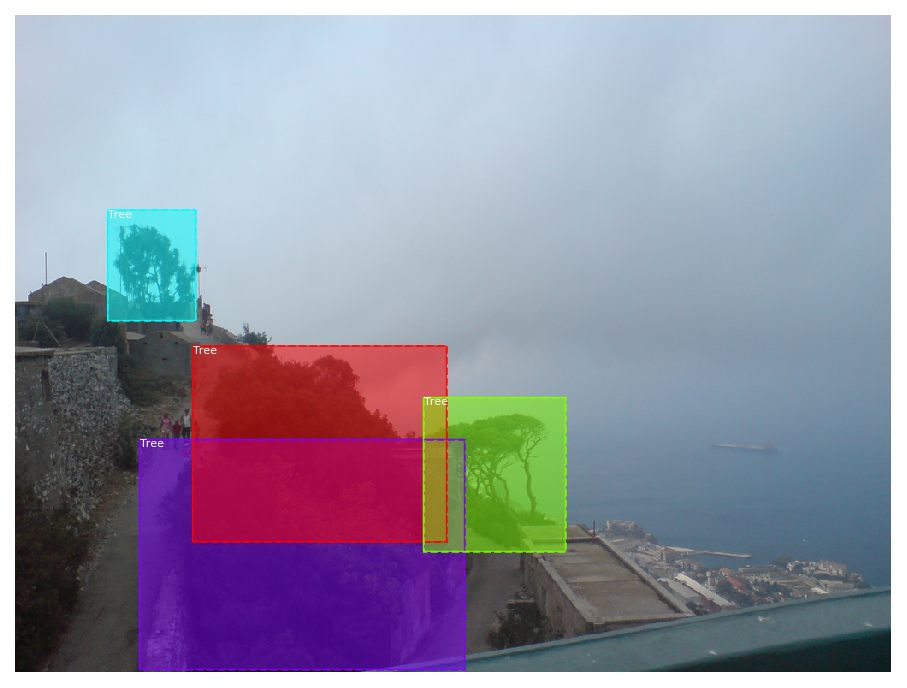

In [15]:
# two build-in functions
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

image_id = 18056
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask) # build-in function bbox=bounding box
display_instances(image,bbox,mask,class_ids,train_set.class_names)

In [16]:
#############################################################################################
#Train
#############################################################################################

In [17]:
from mrcnn.config import Config
# define a configuration for the model
class OpenImageConfig(Config):
    # GIve the configutation a recognizable name
    NAME = "OpenImage_cfg"
    #Number of classes 
    NUM_CLASSES = 1 + len(class_file)
    #Number of training steps per epoch
    # here, the number shows how many images you use in one "epoch"
    # but epoch here is not same to the "epoch" = used all the dataset once
    # it just for the information in keras that give you one feedback
    STEPS_PER_EPOCH = 1000
    
    
    #see https://github.com/matterport/Mask_RCNN/issues/921 
    # issue I met when setting GPU_COUNT > 1 => midify the code
    # see https://github.com/matterport/Mask_RCNN/issues/875
    # why more GPUs will be slower? => batch size = GPU_COUNT*IMAGES_PER_GPU 
    # each "epoch" process batch_size*STEPS_PER_EPCOH images
    GPU_COUNT = 3
    IMAGES_PER_GPU = 3
    
config = OpenImageConfig()

In [18]:
from mrcnn.model import MaskRCNN
# define the model
model = MaskRCNN(mode='training',model_dir='./',config = config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


In [19]:
# load weights (mscoco, downloaded)
# clss-specific output layers are removed by 'exclude' argument
model.load_weights('mask_rcnn_coco.h5',by_name=True,exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_bbox","mrcnn_mask"])

In [ ]:
# train the model (output layers or 'heads')
# it seems that the original code cannot run with the latest keras 
# see https://github.com/matterport/Mask_RCNN/issues/1754 
# replace self.keras_model.metrics_tensors.append(loss)
# by self.keras_model.add_metric(loss, name)
#line 2199 in model.py
model.train(train_set,test_set,learning_rate=config.LEARNING_RATE,epochs=45,layers='heads')

# A model file is created and saved at the end of each epoch -> 'kangaroo_cfg'


Starting at epoch 0. LR=0.001

Checkpoint Path: ./openimage_cfg20191112T1057/mask_rcnn_openimage_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/24
 998/1000 [============================>.] - ETA: 2s - loss: 1.9884 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 0.5370 - mrcnn_class_loss: 0.5738 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.4365

Process ForkPoolWorker-32:
Process ForkPoolWorker-20:
Process ForkPoolWorker-35:
Process ForkPoolWorker-24:
Process ForkPoolWorker-9:
Process ForkPoolWorker-37:
Process ForkPoolWorker-31:
Process ForkPoolWorker-33:
Process ForkPoolWorker-2:
Process ForkPoolWorker-34:
Process ForkPoolWorker-38:
Process ForkPoolWorker-46:
Process ForkPoolWorker-23:
Process ForkPoolWorker-1:
Process ForkPoolWorker-18:
Process ForkPoolWorker-3:
Process ForkPoolWorker-47:
Process ForkPoolWorker-15:
Process ForkPoolWorker-39:
Process ForkPoolWorker-25:
Process ForkPoolWorker-30:
Process ForkPoolWorker-12:
Process ForkPoolWorker-43:
Process ForkPoolWorker-14:
Process ForkPoolWorker-7:
Process ForkPoolWorker-28:
Traceback (most recent call last):
Process ForkPoolWorker-22:
Process ForkPoolWorker-45:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Process ForkPoolWorker-29:
Process ForkPoolWorker-40:
Process ForkPoolWorker-41:
Traceback (most recent call last):
Process ForkPoolWorker-48:
Traceback

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/

KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  